# Predicting Apple stock price by ARMA Model

In [2]:
pip uninstall yfinance

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/e9/43/93ea65227c938a0a4a8925d7f054b050ea743044b887170da9eca210635a/yfinance-0.2.28-py2.py3-none-any.whl.metadata
  Using cached yfinance-0.2.28-py2.py3-none-any.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 9.0 MB/s eta 0:00:00:00:0100:01
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Using cached lxml-4.9.3.tar.gz (3.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached yfinance-0.2.28-py2.py3-none-any.whl (65 kB)
  Created wheel for lxml: filename=lxml-4.9.3-cp37-cp37m-macosx_10_9_x86_64.whl size=1818904 sha256=b219bbed5651b4526667533f4ecdf60d8f29c6c74ca49c6b9dac219b285a64a2
  Stored in directory: /Users/myyntiimac/Library/Caches/pip/wheels/8a/59/f3/e5e5f360eca8ee8a1f07c529f74d93222604ad5402b565af88
Successfully built lxml

In [4]:
pip install statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 10.2 MB/s eta 0:00:0000:0100:01
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Using cached scipy-1.7.3-cp37-cp37m-macosx_10_9_x86_64.whl (33.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn


  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
#Purpose: It's a library for adding progress bars to loops and iterables.
#In the code, it's used with 'tqdm' to show progress when iterating through data.
pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 432.9 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 607.2 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf

In [10]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

##Simulated trading is a crucial step in the development and validation of trading strategies, as it allows traders and investors to make informed decisions about whether to deploy a strategy in real markets. It also helps in understanding how the strategy might perform in various market scenarios and helps identify potential pitfalls or limitations.

simulation typically involves using historical price data, transaction costs, and other relevant market variables to mimic the behavior of a trader following the trading strategy's rules.

Keep in mind that while simulated trading provides valuable insights, real-world trading involves factors such as liquidity, slippage, and market impact that may not be fully captured in simulations. Therefore, live testing and careful risk management are essential steps after successful simulation.

In [11]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1
          #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [12]:
#Read data 
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)


In [13]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

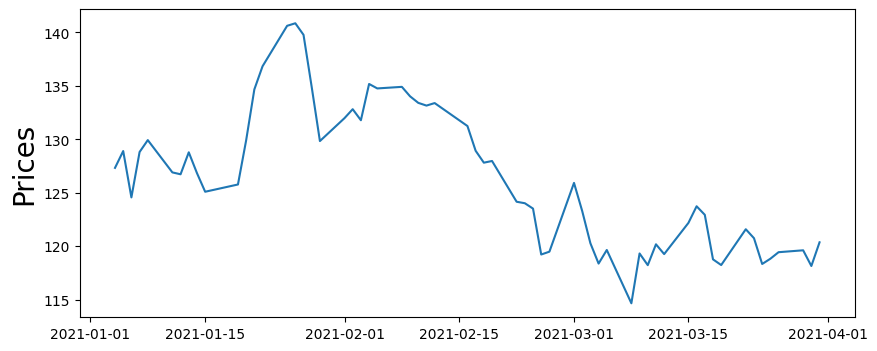

In [14]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

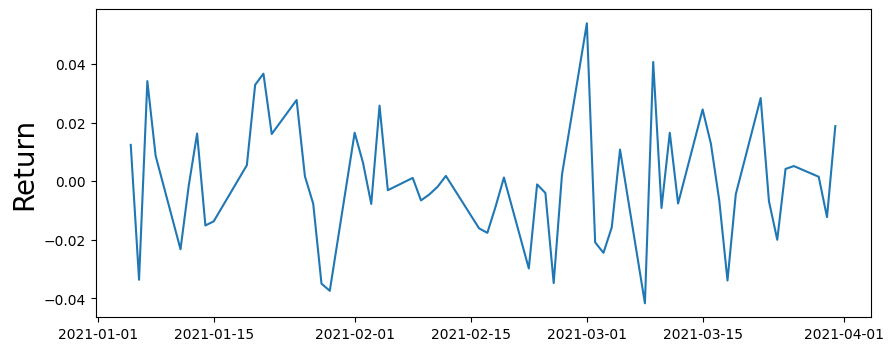

In [15]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

Insight: Return is morelike  stationary than Price, Then using the reurn  and see this stock is buy or not based on how stock price is one day and next(if the price is less than 0 , stock price go down, and some days more than 0 , stock price going up )

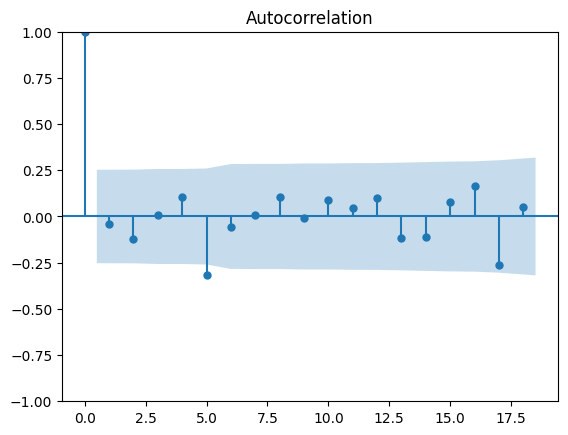

In [16]:
# find acf and pacf to find order for ARMA model which we want to build, 
#in here we try to find spike outside of blue window
plot_acf(returns)
plt.show()

In [ ]:
insight: leg of five days acf signal , inform mA part of model

/Users/myyntiimac/myenv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


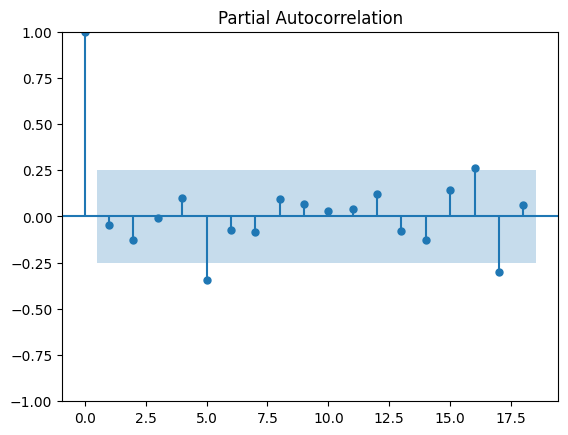

In [17]:
plot_pacf(returns)
plt.show()

insight: spike at 5, AR part of model, its five,beacuse stock market is close for wekend , and its stay for monday to friday

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 5606.22it/s]


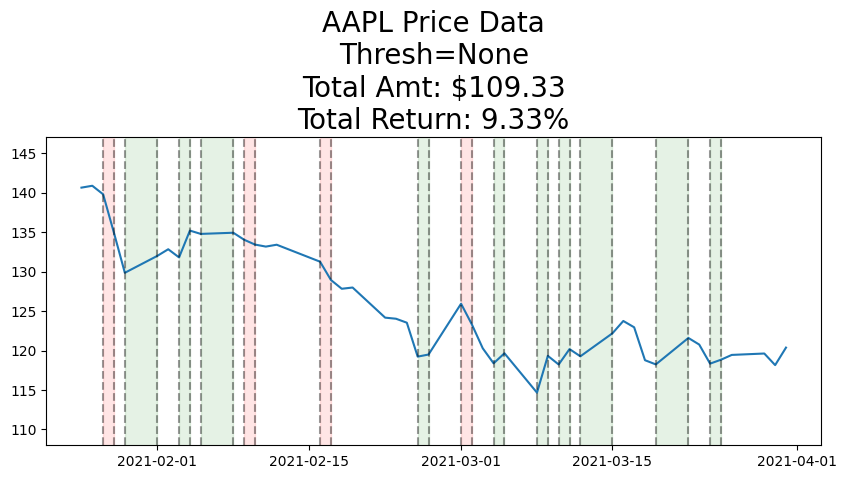

109.32972203042166

In [18]:
# Let see with baseline model purpose of a baseline model is to establish a basic level of performance or behavior that any more sophisticated model should aim to improve upon. 
#It provides a benchmark or reference point for evaluating the effectiveness of more complex models.

run_simulation(returns, prices, 100, 0.5, None, verbose=False)

Insight: basically everyday randomly chose whether need to buy or not and subsequent day it sells , no matter its high or low  , in here red window start when stock price down, and green window when stock price up. you see the a lot of green than red , that means stock price increa more decrease . we start with 100 doller in entire period where random buying selling happen , End of period is 109.32, we profit 9.23 doller or 9%, But its random, one possible outcome , but we can do many time and see the average 

# Run the simulation multiple times and find the average 
#for _ in range(1000)]: This part of the code is a list comprehension that runs the run_simulation function 1000 times.
The results of each simulation, which represent the final amount of money in the portfolio after running the trading strategy, are collected in a list called final_amts.

After running this code, final_amts will contain 1000 values, each representing the final portfolio value after running the simulation with the specified parameters 1000 times. These values can be used for statistical analysis to assess the performance and variability of the trading strategy under the given conditions.

#By running the simulation multiple times, you can assess the variability and distribution of outcomes that the trading strategy might produce. This information can be used to analyze the strategy's performance, understand its potential risks and rewards, and make informed decisions about whether to implement it in a real trading environment. It also helps you estimate statistical measures like the expected return and risk associated with the strateg


In [19]:


final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 5182.05it/s]


/Users/myyntiimac/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


Text(0.5, 1.0, 'Avg: $95.09\nSD: $6.58')

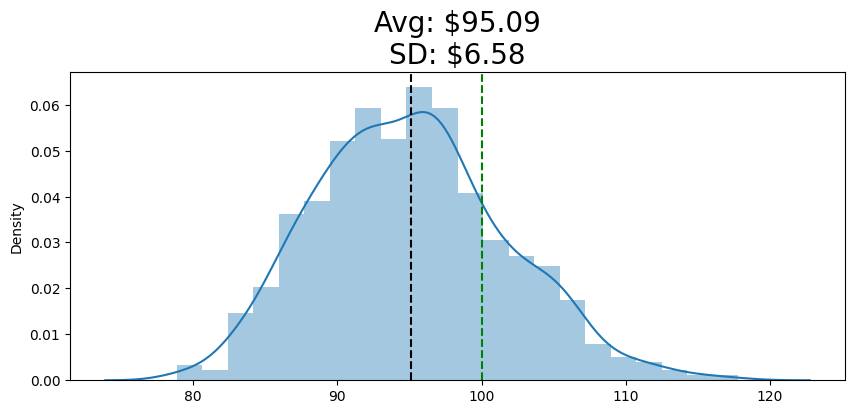

In [20]:
#Lets see the rsult of final amount in plot 
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

In [ ]:
Insight: Average is 95.09 , so historically we lossing the money 

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 4933.47it/s]


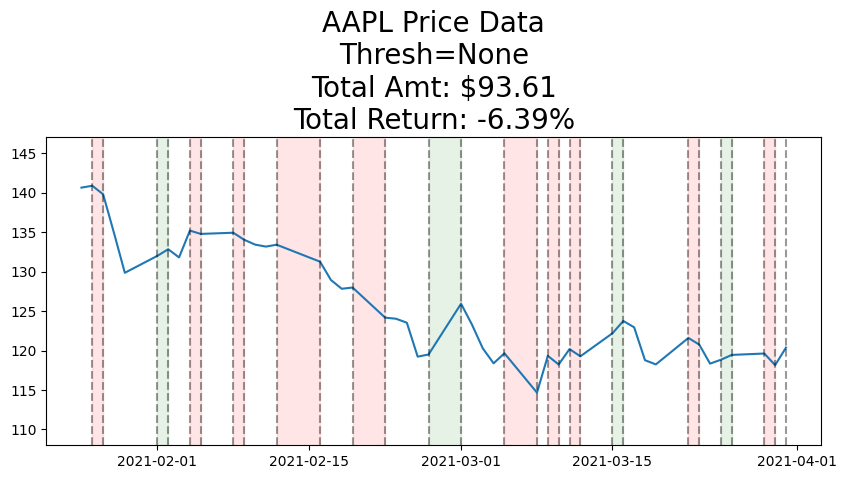

93.60993064441116

In [21]:

#If Last Return was Positive, Buy
# and we sell day after that 
run_simulation(returns, prices, 100, 'last', None, verbose=False)

Insight: so in here before green bar start every price is going up, we can buy, its good dicision , but if we select red one . its bad dicision because its going down after day .  as we are doing random , we lost money 

Notes:what we do everday ,we forcast what the stock retun would be following day , if predicted return is bigger than the trashhold then you can buy the stock 

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 4260.90it/s]


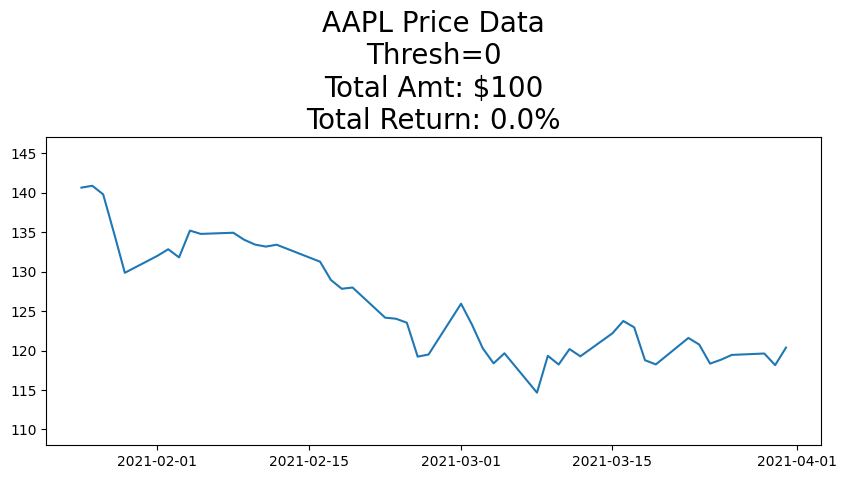

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 4530.34it/s]


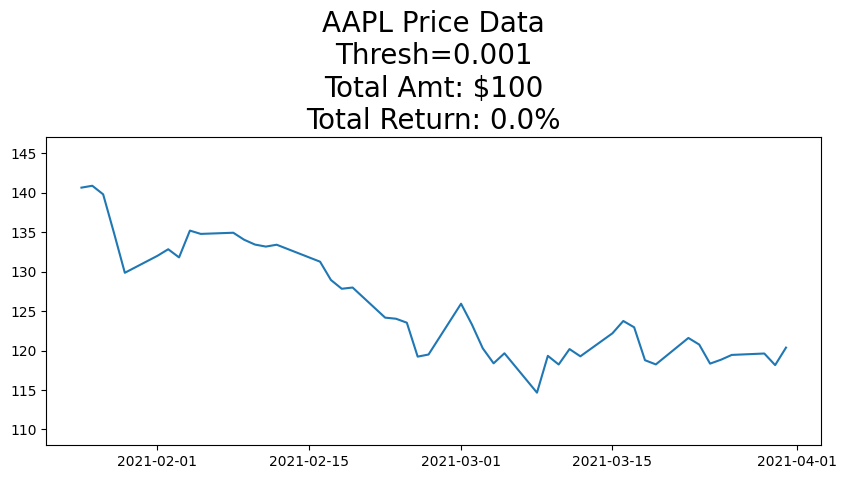

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 4407.79it/s]


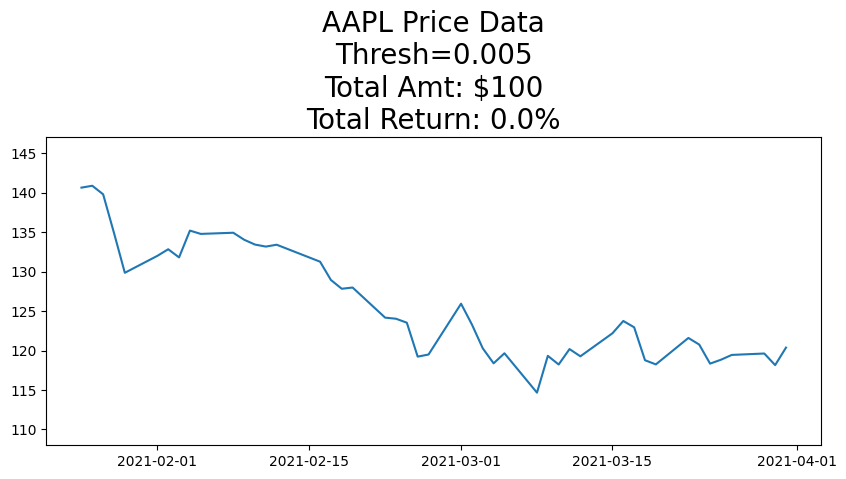

In [22]:
#Try AR(1) Model
#This allows you to assess how the trading strategy's performance varies with different threshold settings.
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

you see we are not losing the money, based on this strategy 

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 4430.26it/s]


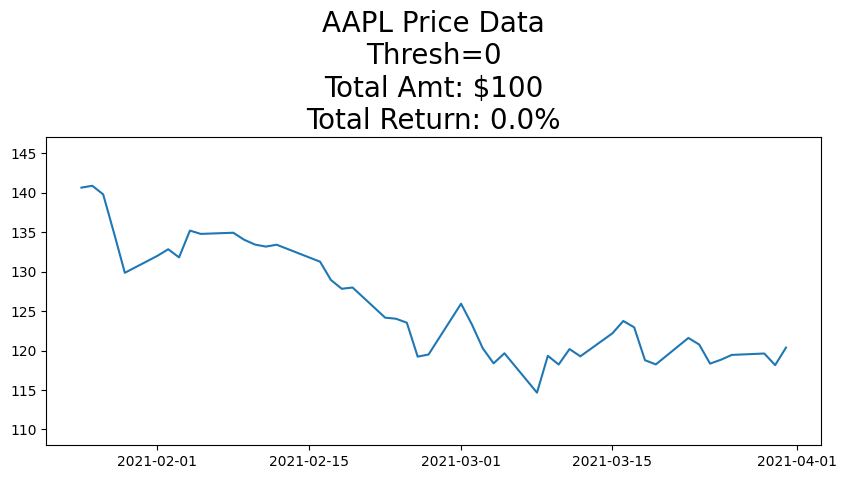

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 4175.79it/s]


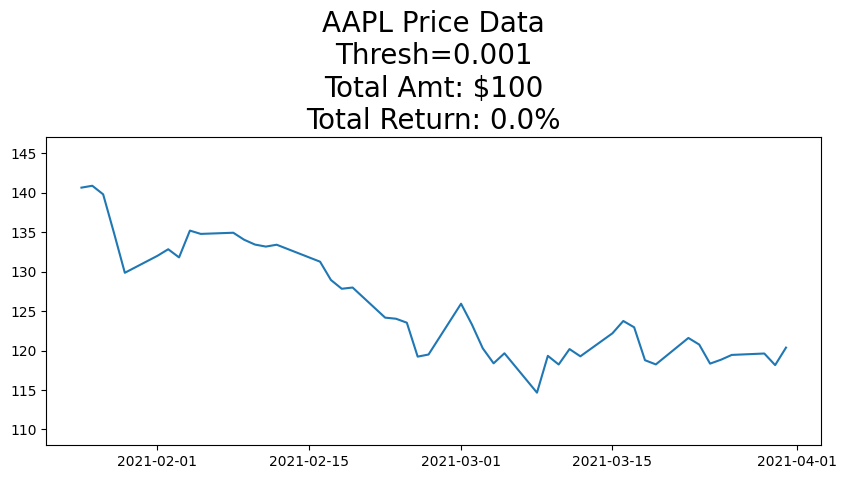

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 4460.38it/s]


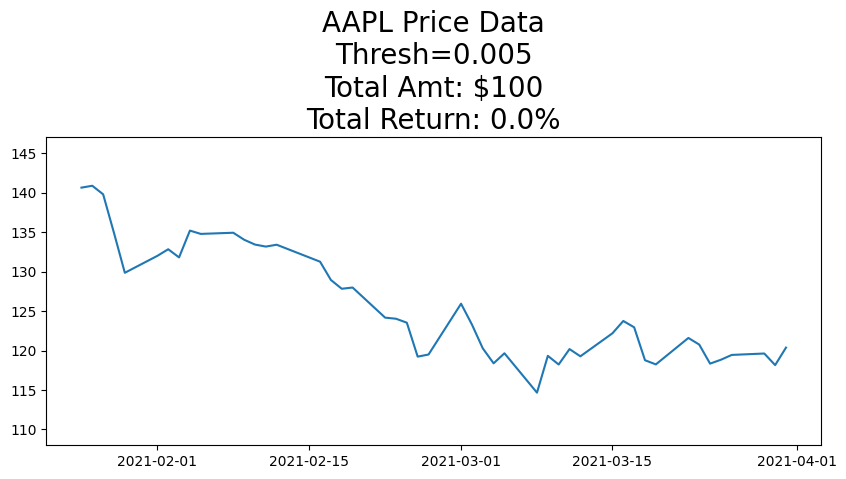

In [23]:
#Try ARMA(5,5) Model
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)

Insight: in here our base line model behaving well than ARMA model 
    Review Model Assumptions: Revisit the assumptions and parameters of both models. Ensure that the ARMA model is correctly specified for your dataset and that it aligns with the underlying principles of financial markets.

Data Quality: Check the quality of your historical data. Data issues, such as missing values, outliers, or inaccuracies, can significantly impact model performance. Clean and preprocess the data appropriately.

Hyperparameter Tuning: If you haven't already, perform hyperparameter tuning for your ARMA model. Adjust the model's parameters, such as the order of the autoregressive and moving average components (p and q), to find the optimal settings for your dataset.

Feature Engineering: Consider whether additional features or indicators could improve the performance of your ARMA model. Financial data often benefits from the inclusion of relevant indicators, such as technical indicators or market sentiment data.

Alternative Models: If the ARMA model doesn't perform well, explore alternative time series forecasting models. This could include more sophisticated models like GARCH (Generalized Autoregressive Conditional Heteroskedasticity), machine learning algorithms, or deep learning models.

Ensemble Models: Experiment with ensemble methods that combine predictions from multiple models, including the baseline model and the ARMA model. Ensemble techniques can sometimes improve overall performance.

Risk Management: Consider incorporating risk management techniques into your trading strategy. Even if a model doesn't outperform the baseline, proper risk management can help protect your capital.

Backtesting: Conduct extensive backtesting of both models to understand their historical performance. Ensure that your backtesting methodology is robust and realistic.

Market Conditions: Consider whether market conditions during the simulation period may have influenced the results. Financial markets can be affected by various external factors, and models may perform differently in different market regimes.

Portfolio Diversification: Instead of relying solely on one model, consider diversifying your portfolio by combining multiple strategies or models. This can help mitigate risks associated with individual models.

Consult Experts: Seek input from domain experts or quantitative analysts with expertise in financial modeling and trading strategies. They can provide valuable insights and guidance.

Acceptance of Results: It's important to accept that not all trading strategies or models will consistently outperform the market. If the baseline model consistently delivers better results, it may be a sign that simple strategies are more effective in your specific context.

Remember that the choice of the best model depends on the specific goals, data, and market conditions. The performance of a model in a simulation may not always translate directly to real-world trading, so proceed with caution and consider the broader context when making decisions.





